통계적 사고 (2판) 연습문제 ([thinkstats2.com](thinkstats2.com), [think-stat.xwmooc.org](http://think-stat.xwmooc.org))<br>
Allen Downey / 이광춘(xwMOOC)

## 연습문제 10.1

BRFSS에서 나온 데이터를 사용해서, log(체중) 대비 신장에 대한 선형 최소자승적합을 계산하라. 변수중 하나가 로그 변환된 이와 같은 모형에 대해서 추정된 모수를 나타내는 가장 좋은 방식은 어떻게 될까요? 만약 누군가의 체중을 추측하려고 한다면, 신장을 아는 것이 얼마나 도움이 될까?

NSFG와 마찬가지로, BRFSS는 일부 집단을 과다표집(oversampling)하고 각 응답자에 대해서 표집 가중치 정보를 제공한다. BRFSS 데이터에서, 해당 가중치에 대한 변수명은 totalwt다. 가중치를 갖는, 갖지 않는 재표집을 사용해서, BRFSS에 나온 평균 응답자 신장, 평균에 대한 표준오차, 90% 신뢰구간을 추정하시오. 보정 가중치가 추정값에 얼마나 영향을 주는가?

BRFSS 데이터를 불러들여서, 신장과 log 체중을 추출한다.

In [1]:
import brfss
import numpy as np

%matplotlib inline

In [6]:
df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
weights = np.log10(weights)

절편과 기울기를 추정한다.

In [7]:
import thinkstats2
inter, slope = thinkstats2.LeastSquares(heights, weights)
inter, slope

(0.99308041639176259, 0.0052814541694181016)

데이터에 대한 산점도와 적합선을 보여준다.

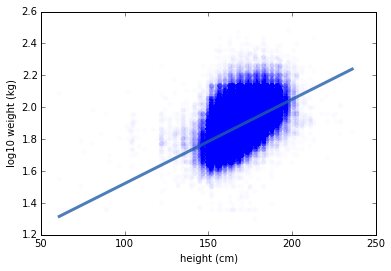

In [8]:
import thinkplot
thinkplot.Scatter(heights, weights, alpha=0.01)
fxs, fys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fxs, fys)
thinkplot.Config(xlabel='height (cm)', ylabel='log10 weight (kg)', legend=False)

동일한 도식화를 하지만, 역변환을 적용해서 선형(log 아님) 척도로 체중을 나타낸다.

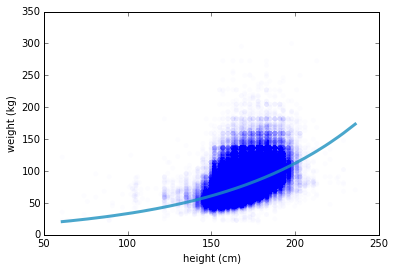

In [9]:
thinkplot.Scatter(heights, 10**weights, alpha=0.01)
fxs, fys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fxs, 10**fys)
thinkplot.Config(xlabel='height (cm)', ylabel='weight (kg)', legend=False)

잔차 백분위수를 도식화한다.

선들이 범위 대부분에 걸쳐 평평하다. 관계가 선형임을 나타낸다.

선들이 거의 평행하다. 잔차 분산이 범위에 걸쳐 같음을 나타낸다.

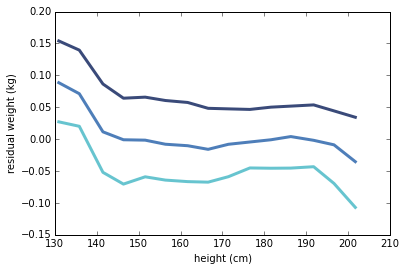

In [10]:
res = thinkstats2.Residuals(heights, weights, inter, slope)
df['residual'] = res

bins = np.arange(130, 210, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

means = [group.htm3.mean() for i, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.residual) for i, group in groups][1:-1]

thinkplot.PrePlot(3)
for percent in [75, 50, 25]:
    ys = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(means, ys, label=label)
    
thinkplot.Config(xlabel='height (cm)', ylabel='residual weight (kg)', legend=False)

상관을 계산한다.

In [11]:
rho = thinkstats2.Corr(heights, weights)
rho

0.53172826059835865

결정계수를 계산한다.

In [12]:
r2 = thinkstats2.CoefDetermination(weights, res)
r2

0.28273494311894265

$R^2 = \rho^2$ 임을 확증한다.

In [13]:
rho**2 - r2

1.3378187446733136e-14

Std(ys)를 계산하는데, 신장을 사용하지 않은 예측 RMSE가 된다.

In [14]:
std_ys = thinkstats2.Std(weights)
std_ys

0.10320725030004974

Std(res)를 계산하는데, 신장을 사용하는 예측 RMSE가 된다.

In [15]:
std_res = thinkstats2.Std(res)
std_res

0.08740777080416139

신장 정보가 RMSE를 얼마나 줄이는가? 약 15%

In [16]:
1 - std_res / std_ys

0.15308497658793585

재표본추출을 사용해서 절편과 기울기에 대한 표집분포를 계산하시오.

In [17]:
t = []
for _ in range(100):
    sample = thinkstats2.ResampleRows(df)
    estimates = thinkstats2.LeastSquares(sample.htm3, np.log10(sample.wtkg2))
    t.append(estimates)

inters, slopes = zip(*t)

기울기에 대한 표집분포를 도식화하시오.

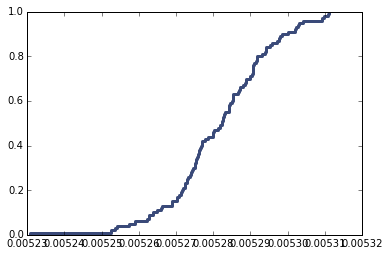

In [19]:
cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf)
thinkplot.Show(legend=False)

기울기에 대한 p-값을 계산하시오.

In [20]:
pvalue = cdf[0]
pvalue

0.0

기울기 90% 신뢰구간을 계산하시오.

In [21]:
ci = cdf.Percentile(5), cdf.Percentile(95)
ci

(0.0052573684005693686, 0.0053031427019740842)

표집분포의 평균을 계산하시오.

In [22]:
mean = thinkstats2.Mean(slopes)
mean

0.0052816475557694456

표집분포에 대한 표준편차를 계산하시오. 이것이 표준오차다.

In [23]:
stderr = thinkstats2.Std(slopes)
stderr

1.3932953469804109e-05

표집가중치를 사용해서 재표본추출하시오.

In [24]:
def ResampleRowsWeighted(df, column='finalwt'):
    """Resamples a DataFrame using probabilities proportional to given column.

    df: DataFrame
    column: string column name to use as weights

    returns: DataFrame
    """
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

표집분포를 요약하시오.

In [25]:
def Summarize(estimates):
    mean = thinkstats2.Mean(estimates)
    stderr = thinkstats2.Std(estimates)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.Percentile(5), cdf.Percentile(95)
    print('mean', mean)
    print('stderr', stderr)
    print('ci', ci)

가중치 없이 행을 재표본추출하고 결과를 요약하시오.

In [26]:
estimates_unweighted = [thinkstats2.ResampleRows(df).htm3.mean() for _ in range(100)]
Summarize(estimates_unweighted)

('mean', 168.95556271347442)
('stderr', 0.01614643033211284)
('ci', (168.93035429171971, 168.98151741142706))


가중치를 갖고 행을 재표본추출하시오. 만약 표집 가중치를 고려하면, 추정된 평균 신장이 거의 2cm 더 크고, 차이는 표집오차보다 훨씬 크다.

In [28]:
estimates_weighted = [ResampleRowsWeighted(df).htm3.mean() for _ in range(100)]
Summarize(estimates_weighted)

('mean', 170.4969352402029)
('stderr', 0.016824851764466277)
('ci', (170.46758220659271, 170.52078407000951))
